<h1>Read In Data<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import logging
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import sympy
import numpy as np

from sympy import Symbol, solve
from typing import Union, List, Callable, Optional
from tqdm import tqdm
from util.geobra import Point, Edge, Util
from util.graph import Graph, Vertex
from mpl_toolkits.mplot3d import Axes3D

In [3]:
points = pd.read_csv('./file1/f1.csv',header=0,sep=',')
bottom_points = pd.read_csv('./file1/f2.csv',header=0,sep=',')
face_frame = pd.read_csv('./file1/f3.csv',header=0,sep=',')

In [4]:
print(points.head())

   Unnamed: 0 INDEX          X         Y           Z
0           0    A0  61.589702  0.000000 -294.018483
1           1    B1  71.268398  3.073899 -291.807330
2           2    C1  67.416241 -8.490596 -292.614263
3           3    D1  55.461324 -8.320943 -295.118527
4           4    E1  51.924668  3.347964 -295.859370


In [5]:
print(bottom_points.head())

   Unnamed: 0 INDEX         X1        Y1          Z1         X2        Y2  \
0           0    A0  62.475782  0.000000 -298.248474  62.069831  0.000000   
1           1    B1  72.268228  3.117061 -295.900901  71.798460  3.096835   
2           2    C1  68.371870 -8.610485 -296.760924  67.927570 -8.554516   
3           3    D1  56.249910 -8.438658 -299.312541  55.884362 -8.383804   
4           4    E1  52.653454  3.395003 -300.011659  52.311201  3.372988   

           Z2  
0 -296.310536  
1 -293.977557  
2 -294.832245  
3 -297.367366  
4 -298.061604  


In [6]:
face_frame.head()

,I1,I2,I3
0,A0,B1,C1
1,A0,B1,A1
2,A0,C1,D1
3,A0,D1,E1
4,A0,E1,A1


In [7]:
vertex_list: List[Vertex] = []
print("Getting Information...")
for point_num in tqdm(range(len(points))):
    vertex_list.append(Vertex(name=points["INDEX"][point_num],
                              x=torch.tensor(points["X"][point_num],requires_grad = True),
                              y=torch.tensor(points["Y"][point_num],requires_grad = True),
                              z=torch.tensor(points["Z"][point_num],requires_grad = True),))

Getting Information...


100%|██████████| 2226/2226 [00:00<00:00, 8766.97it/s]


In [8]:
print("updating adjacent relationships...")
for face_num in tqdm(range(len(face_frame))):
    v1_name = face_frame["I1"][face_num]
    v2_name = face_frame["I2"][face_num]
    v3_name = face_frame["I3"][face_num]
    v1, v2, v3 = None, None, None
    for v in vertex_list:
        if v.name == v1_name: v1 = v
        if v.name == v2_name: v2 = v
        if v.name == v3_name: v3 = v
        if v1 and v2 and v3: break
    assert v1 and v2 and v3
    v1.add_adjacent(v2)
    v1.add_adjacent(v3)
    v2.add_adjacent(v3)
    v2.add_adjacent(v1)
    v3.add_adjacent(v1)
    v3.add_adjacent(v2)

graph = Graph(vertex_list)
graph.update_edge()

updating adjacent relationships...


100%|██████████| 2226/2226 [00:13<00:00, 169.76it/s]


In [9]:
for i in range(2):
    print(graph.vertex_list[i])
print(isinstance(graph.vertex_list[0].x, torch.Tensor))

class Vertex:
	name: A0
	position: (61.58970228881544, 0.0, -294.0184833849312)
	adjacent vertex: ['B1', 'C1', 'A1', 'D1', 'E1']
class Vertex:
	name: B1
	position: (71.26839782471706, 3.073898556710084, -291.8073302318516)
	adjacent vertex: ['C1', 'A0', 'A1', 'B3', 'A3', 'B2']
True


# Start to Load information for furthur calculation

In [11]:
class Vertex_Info(object):
    def __init__(self, fix_point_on_ground:Point, original_actuator_point:Point, init_pos:Point):
        self.init_pos:Point = init_pos
        self.fix_point_on_ground: Point = fix_point_on_ground
        self.original_actuator_point: Point = original_actuator_point

        self.rope_length = self.tensor2float(Util.distance(self.init_pos, self.original_actuator_point))
        
        self.zeta: Optional[float] = None  # the ratio actuator_length's difference w.r.t the original length

    def __str__(self):
        return "class Vertex_Info: \n\t init_pos = {} \n\t rope_length = {:.5f} \n\t fix_point_on_ground = {} \n\t original_actuator_point = {}".\
            format(self.point2pos(self.init_pos), 
                   self.rope_length,
                   self.point2pos(self.fix_point_on_ground),
                   self.point2pos(self.original_actuator_point))
    
    
    def get_zeta(self, x,y,z)->float:
        """ input the point on the end of the rope, return the acturator's change ratio"""
        zeta = Symbol("zeta")
        x0,y0,z0 = self.point2pos(self.fix_point_on_ground)  # point on ground
        x1,y1,z1 = self.point2pos(self.original_actuator_point)  # point on actuator
        x2 = self.tensor2float(x)
        y2 = self.tensor2float(y)
        z2 = self.tensor2float(z)
        
        x_end = x1 + (x1-x0) * zeta
        y_end = y1 + (y1-y0) * zeta
        z_end = z1 + (z1-z0) * zeta
        res = sympy.solve((x2-x_end)**2+(y2-y_end)**2+(z2-z_end)**2-self.rope_length**2, zeta)
        
        self.zeta = min(res)
        return self.zeta
     
    def acturator_length_offset(self,x,y,z):
        return self.get_zeta(x,y,z) * Util.distance(self.original_actuator_point, self.fix_point_on_ground)
    
    def get_acturator_pos(self,x,y,z):
        """ input the point on the end of the rope, return the acturator's changed position"""

        zeta = Symbol("zeta")
        x0,y0,z0 = self.point2pos(self.fix_point_on_ground)  # point on ground
        x1,y1,z1 = self.point2pos(self.original_actuator_point)  # point on actuator
        x2 = self.tensor2float(x)
        y2 = self.tensor2float(y)
        z2 = self.tensor2float(z)
        
        x_end = x1 + (x1-x0) * zeta
        y_end = y1 + (y1-y0) * zeta
        z_end = z1 + (z1-z0) * zeta
        res = sympy.solve((x2-x_end)**2+(y2-y_end)**2+(z2-z_end)**2-self.rope_length**2, zeta)
        
        self.zeta = min(res)
        x_end = x1 + (x1-x0) * self.zeta
        y_end = y1 + (y1-y0) * self.zeta
        z_end = z1 + (z1-z0) * self.zeta
        return (x_end, y_end, z_end)
        
    
    @staticmethod
    def tensor2float(num):
        if isinstance(num, float):
            return num
        elif isinstance(num, torch.Tensor):
            assert num.shape == ()
            return num.item()
        elif isinstance(num, int):
            return float(num)
        logging.warning("invalid type {} in Info.tensor2float".format(type(num)))
        return num

    @staticmethod
    def point2pos(point:Point):
        return (point.x, point.y, point.z)

In [12]:
class Edge_Info(object):
    def __init__(self, length_original:Union[float, torch.Tensor]):
        self.length_original: float = self.tensor2float(length_original)
        self.max_offset: float = self.length_original * 7E-4
    
    @staticmethod
    def tensor2float(num):
        if isinstance(num, float):
            return num
        elif isinstance(num, torch.Tensor):
            assert num.shape == ()
            return num.item()
        elif isinstance(num, int):
            return float(num)
        logging.warning("invalid type {} in Info.tensor2float".format(type(num)))
        return num

    def __str__(self):
        return "class Edge_Info: \n\t length_original = {} \n\t max_offset = {}".\
            format(self.length_original, 
                   self.max_offset,)
        

In [13]:
print("getting vertex information for further calculation...")
for vertex in tqdm(graph.vertex_list):
    name = vertex.name
    info = bottom_points.loc[bottom_points['INDEX'] == name]
    fix_point_on_ground   = Point(float(info["X1"]), float(info["Y1"]), float(info["Z1"]), name=name+"_fix_point_on_ground")
    original_actuator_point = Point(float(info["X2"]), float(info["Y2"]), float(info["Z2"]), name=name+"_original_actuator_point")
    x_init = Vertex_Info.tensor2float(vertex.x)
    y_init = Vertex_Info.tensor2float(vertex.y)
    z_init = Vertex_Info.tensor2float(vertex.z)
    init_pos = Point(x_init, y_init, z_init, name=name+"_init_pos")
    vertex.info = Vertex_Info(fix_point_on_ground=fix_point_on_ground, original_actuator_point=original_actuator_point, init_pos=init_pos)


print(graph.vertex_list[10])
print(graph.vertex_list[10].info)

getting vertex information for further calculation...


100%|██████████| 2226/2226 [00:03<00:00, 729.68it/s] 

class Vertex:
	name: C3
	position: (61.26504578246872, -16.81531897185969, -293.60516602804626)
	adjacent vertex: ['C1', 'D1', 'C2', 'D2', 'C5', 'C6']
class Vertex_Info: 
	 init_pos = (61.26504578246872, -16.81531897185969, -293.60516602804626) 
	 rope_length = 2.22971 
	 fix_point_on_ground = (62.12337159852943, -17.051223737705403, -297.71969377676) 
	 original_actuator_point = (61.71953928079958, -16.940341662472377, -295.78447922417183)


# Test

In [14]:
print("getting edge information for further calculation...")
for edge in tqdm(graph.edge_list):
    info = Edge_Info(length_original=edge.length)
    edge.info = info

print(graph.edge_list[10])
print(graph.edge_list[10].info)

getting edge information for further calculation...


100%|██████████| 6525/6525 [00:00<00:00, 18961.87it/s]

class Edge_Info: 
	 length_original = 12.215570362860669 
	 max_offset = 0.008550899254002469


In [15]:
def isworking(point:Point):
    return (point.x ** 2 + point.y ** 2) < 150**2


In [16]:
vertex_list_working = []
vertex_list_fixing = []
vertex_list_idling = []
for i, vertex in enumerate(graph.vertex_list):
    if isworking(vertex.info.init_pos):
        vertex_list_working.append(vertex)
    elif vertex.n_adjacent < 5:
        vertex_list_fixing.append(vertex)
    else:
        vertex_list_idling.append(vertex)

print(len(vertex_list_working))
print(len(vertex_list_fixing))
print(len(vertex_list_idling))

692
130
1404


In [17]:
edge_list_working = []
edge_list_idling = []
edge_list_fixing = []
for e in graph.edge_list:
    if e.v1 in vertex_list_idling or e.v2 in vertex_list_idling:
        edge_list_idling.append(e)
    elif e.v1 in vertex_list_working and e.v2 in vertex_list_working:
        edge_list_working.append(e)
    else:
        edge_list_fixing.append(e)
print(len(edge_list_working))
print(len(edge_list_fixing))
print(len(edge_list_idling))


1986
110
4429


# Start calculating!

## initialization

In [18]:
# 300.89097588
def calc_z(x, y, h=300.89097588, R=300.4):
    return (x**2+y**2) / (4*(h-R+0.466*R))-h

In [19]:
for v in vertex_list_working:
    v.z = calc_z(v.x, v.y)

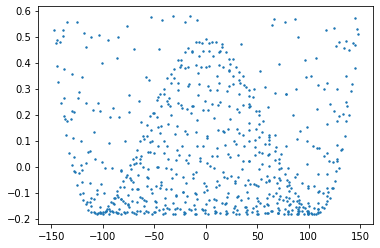

In [20]:
l0 = []
l1 = []
l2 = []
l3 = []
for working_vertex in vertex_list_working:
    l0.append(working_vertex.x.item())
    l1.append(working_vertex.z.item())
    l2.append(working_vertex.info.init_pos.z)
    l3.append(working_vertex.info.init_pos.z-working_vertex.z.item())
# plt.scatter(l0,l1)
plt.scatter(l0,l3, s=2)


In [21]:
def draw_offset_difference():
    x_working, y_working, z_working = [],[],[]
    x_fixing , y_fixing , z_fixing  = [],[],[]
    x_idling , y_idling , z_idling  = [],[],[]
    x_critic , y_critic , z_critic  = [],[],[]

    for v in tqdm(vertex_list_working,):
        offset = v.info.acturator_length_offset(v.x, v.y, v.z)
        if offset < 0.6:
            x_working.append(float(v.x))
            y_working.append(float(v.y))
            z_working.append(float(offset))
        else:  
            x_critic.append(float(v.x))
            y_critic.append(float(v.y))
            z_critic.append(float(offset))

    for v in tqdm(vertex_list_idling,):
        offset = v.info.acturator_length_offset(v.x, v.y, v.z)
        x_idling.append(float(v.x))
        y_idling.append(float(v.y))
        z_idling.append(float(offset))

    for v in tqdm(vertex_list_fixing,):
        x_fixing.append(float(v.x))
        y_fixing.append(float(v.y))
        z_fixing.append(float(0.))
        
    fig = plt.figure(figsize=(10, 10))
    ax1 = plt.axes(projection='3d')
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    ax1.set_zlabel("offset")
    ax1.scatter3D(x_critic,  y_critic,  z_critic, cmap='Reds', s = 5)
    ax1.scatter3D(x_fixing,  y_fixing,  z_fixing, c = "b", s = 3)
    ax1.scatter3D(x_idling,  y_idling,  z_idling, cmap='Greens', s = 3)
    ax1.scatter3D(x_working, y_working, z_working, cmap='Yellows', s = 3)
    plt.show()
    print(z_working[:10])


100%|██████████| 130/130 [00:00<00:00, 53778.43it/s]


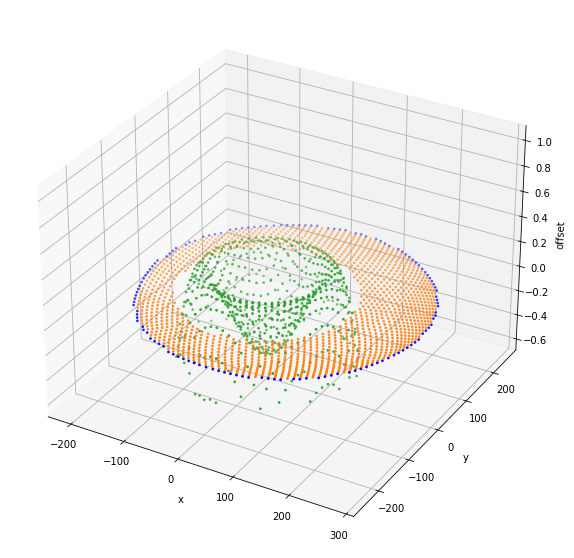

[-0.12177658038433492, -0.027679609200674804, -0.06001637704548557, -0.1751126954595179, -0.21342797370829203, -0.11230811916101402, -0.015611789906699869, 0.05960880978381056, 0.026755988405341213, 0.007332827838354206]


In [22]:
def draw_z_difference():
    x_working_, y_working_, z_working_ = [],[],[]
    x_fixing_ , y_fixing_ , z_fixing_  = [],[],[]
    x_idling_ , y_idling_ , z_idling_  = [],[],[]
    x_critic_ , y_critic_ , z_critic_  = [],[],[]

    for v in tqdm(vertex_list_working,):
        offset = v.z - v.info.init_pos.z
        if offset < 0.6:
            x_working_.append(float(v.x))
            y_working_.append(float(v.y))
            z_working_.append(float(offset))
        else:  
            x_critic_.append(float(v.x))
            y_critic_.append(float(v.y))
            z_critic_.append(float(offset))

    for v in tqdm(vertex_list_idling,):
        offset = v.z - v.info.init_pos.z
        x_idling_.append(float(v.x))
        y_idling_.append(float(v.y))
        z_idling_.append(float(offset))

    for v in tqdm(vertex_list_fixing,):
        offset = v.z - v.info.init_pos.z
        x_fixing_.append(float(v.x))
        y_fixing_.append(float(v.y))
        z_fixing_.append(float(offset))

    fig = plt.figure(figsize=(10, 10))
    ax1 = plt.axes(projection='3d')
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    ax1.set_zlabel("offset")
    ax1.scatter3D(x_critic_,  y_critic_,  z_critic_, cmap='Reds', s = 5)
    ax1.scatter3D(x_fixing_,  y_fixing_,  z_fixing_, c = "b", s = 3)
    ax1.scatter3D(x_idling_,  y_idling_,  z_idling_, cmap='Greens', s = 3)
    ax1.scatter3D(x_working_, y_working_, z_working_, cmap='Yellows', s = 3)
    plt.show()
    print(z_working_[:10])

draw_z_difference()

# Defining the edge_energy function

In [24]:
# hyper parameters:
alpha = 0.1
beta = 0.1
k_timer = 10.

# parameters
D = 30E-3    # m
A = D**2 * 3.1415 / 4
E = 1.8E11
# L = 10   # m
# delta_L = 10 * 7E-4
c1 = E * A

def edge_energy(edge:Edge):
    l0 = edge.info.length_original
    delta_L = torch.abs(edge.length - l0)
    l_max = edge.info.max_offset
    K = c1 / l0
    if delta_L < l_max:
        return 0.5 * K * delta_L ** 2
    else:
        return 0.5 * K * l_max ** 2 + k_timer * K * (delta_L - l_max) * l_max

# Edge Energy test

Text(0, 0.5, 'energy')

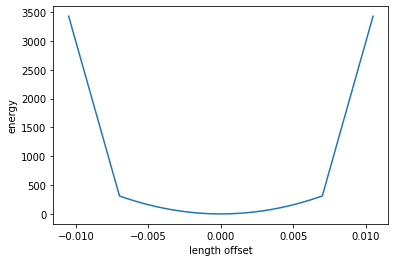

In [25]:

off_set_max = 10*7E-4 * 1.5
x_list = torch.linspace(-off_set_max,off_set_max, 1001)
y_list = []
Origin = Point(0.,0.,0.)
for x in x_list:
    p = Point(x+10., 0.,0.,)
    e = Edge(Origin, p)
    e.info = Edge_Info(length_original=10.,)
    y_list.append(edge_energy(e))
y_list = torch.tensor(y_list)
plt.plot(x_list, y_list)
plt.xlabel("length offset")
plt.ylabel("energy")

In [26]:
!pip install openpyxl

# find a good init value

# Traning the inner part

In [27]:
params_working = []
for v in vertex_list_working:
    params_working.append(v.x)
    params_working.append(v.y)

edge_working_all:List[Edge] = []
for e in tqdm(graph.edge_list,):
    if (e.v1 in vertex_list_working) or (e.v2 in vertex_list_working):
        if e not in edge_working_all:
            edge_working_all.append(e)

print(len(vertex_list_working))
print(len(edge_working_all))

100%|██████████| 6525/6525 [00:03<00:00, 2119.93it/s]

692
2165


In [29]:
train = False
if train:
    ene_list = []
    optimizer = torch.optim.Adam(params = params_working, lr = 0.0001)


    for step in range(400):
        for v in vertex_list_working:
            if isworking(v):
                v.z = calc_z(v.x,v.y)

        total_ene = 0.
        for e in edge_working_all:
            if e.v1 in vertex_list_working:
                e.v1.z = calc_z(e.v1.x, e.v1.y)
            if e.v2 in vertex_list_working:
                e.v2.z = calc_z(e.v2.x, e.v2.y)
            total_ene += edge_energy(e)

        optimizer.zero_grad()
        total_ene.backward()
        optimizer.step()
        ene_list.append(total_ene.detach().item())

        print("[{}][{}]: {}".format("pretrain", step, total_ene.detach().item()))

    name_list = []
    x_list = []
    y_list = []
    z_list = []
    for v in tqdm(graph.vertex_list):
        name_list.append(v.name)
        x_list.append(v.x.detach().item())
        y_list.append(v.y.detach().item())
        z_list.append(v.z.detach().item())

    df = pd.DataFrame({"INDEX": name_list,
                    "X": x_list,
                    "Y": y_list,
                    "Z": z_list,})
    df.to_excel("result_inner1/pretrain.xlsx")
else:
    df = pd.read_excel("file1/final3-2.xlsx")
    print(df.head())
    for v in vertex_list_working:
        v.x = torch.tensor(float(df.loc[df["INDEX"]==v.name]["X"]), requires_grad=True)
        v.y = torch.tensor(float(df.loc[df["INDEX"]==v.name]["Y"]), requires_grad=True)
        v.z = calc_z(v.x, v.y)
    total_ene = 0.
    for e in edge_working_all:
        ene = edge_energy(e)
        total_ene += ene
    print(total_ene.detach().item())

   Unnamed: 0 INDEX          X         Y           Z
0           0    A0  61.573620  0.000486 -294.143768
1           1    B1  71.236877  3.071795 -291.843018
2           2    C1  67.387962 -8.487961 -292.681122
3           3    D1  55.450569 -8.317607 -295.295837
4           4    E1  51.921978  3.349134 -296.073273
4888827.5


In [30]:
name_list = []
x_list = []
y_list = []
z_list = []
for v in tqdm(graph.vertex_list):
    name_list.append(v.name)
    x_list.append(v.x.detach().item())
    y_list.append(v.y.detach().item())
    z_list.append(v.z.detach().item())

df = pd.DataFrame({"INDEX": name_list,
                "X": x_list,
                "Y": y_list,
                "Z": z_list,})
# k_timer *= 1.1
df.to_excel("result_inner1/pretrain.xlsx")

100%|██████████| 2226/2226 [00:00<00:00, 110878.46it/s]


In [31]:
cnt = 0
for e in edge_working_all:
    if torch.abs(e.length-e.info.length_original) >  e.info.max_offset:
        cnt += 1
print(cnt / len(edge_working_all))

0.10900692840646652


# Training the outer part

In [32]:
def energy_idle():
    result = 0.
    for e in edge_list_idling:
        result += edge_energy(e)
    return result

def update_z(point_list:List[Point]):
    for p in point_list:
        p.z = calc_z(p.x, p.y)


params_idle = []
for v in vertex_list_idling:
    params_idle.append(v.x)
    params_idle.append(v.y)
    params_idle.append(v.z)


working_v_list: List[Point] = []
for e_tmp in tqdm(edge_list_idling,):
    if isworking(e_tmp.v1) and (e_tmp.v1 not in working_v_list):
        working_v_list.append(e_tmp.v1)
    if isworking(e_tmp.v2) and (e_tmp.v2 not in working_v_list):
        working_v_list.append(e_tmp.v2)
update_z(working_v_list)

100%|██████████| 4429/4429 [00:00<00:00, 16515.77it/s]


In [33]:
len(working_v_list)

83

In [35]:

train = False
if train:
    epochs = 100 
    steps = 50
    lr = 0.01

    # training

    optimizer = torch.optim.Adam(params = params_idle, lr = 0.0001)
    for step in range(200):
        optimizer.zero_grad()
        total_ene = 0.
        for e in edge_list_idling:
            ene = edge_energy(e)
            ene.backward()
            total_ene += ene.detach().item()
            if isworking(e.v1):
                e.v1.z = calc_z(e.v1.x, e.v1.y)
            if isworking(e.v2):
                e.v2.z = calc_z(e.v2.x, e.v2.y)
        optimizer.step()
        print("[{}][{}]: {}".format("pretrain", step, total_ene))
    
    # saving the result
    name_list = []
    x_list = []
    y_list = []
    z_list = []
    for v in tqdm(graph.vertex_list):
        name_list.append(v.name)
        x_list.append(v.x.detach().item())
        y_list.append(v.y.detach().item())
        z_list.append(v.z.detach().item())

    df = pd.DataFrame({"INDEX": name_list,
                    "X": x_list,
                    "Y": y_list,
                    "Z": z_list,})
    df.to_excel("result_outer1/pretrain.xlsx")
else:
    df = pd.read_excel("file1/final3-2.xlsx")
    print(df.head())
    for v in tqdm(vertex_list_idling,):
        v.x = torch.tensor(float(df.loc[df["INDEX"]==v.name]["X"]),requires_grad=True)
        v.y = torch.tensor(float(df.loc[df["INDEX"]==v.name]["Y"]),requires_grad=True)
        v.z = torch.tensor(float(df.loc[df["INDEX"]==v.name]["Z"]),requires_grad=True)

    total_ene = 0.
    for e in edge_list_idling:
        ene = edge_energy(e)
        total_ene += ene
    print(total_ene.detach().item())

    

   Unnamed: 0 INDEX          X         Y           Z
0           0    A0  61.573620  0.000486 -294.143768
1           1    B1  71.236877  3.071795 -291.843018
2           2    C1  67.387962 -8.487961 -292.681122
3           3    D1  55.450569 -8.317607 -295.295837
4           4    E1  51.921978  3.349134 -296.073273


100%|██████████| 1404/1404 [00:05<00:00, 277.24it/s]


129346.7265625


In [31]:
# cnt = 0
# for e in edge_list_idling:
#     if torch.abs(e.length-e.info.length_original) >  e.info.max_offset:
#         cnt += 1
# print(cnt / len(edge_list_idling))
# print(len(edge_list_idling))
# print(cnt)

100%|██████████| 130/130 [00:00<00:00, 52469.16it/s]


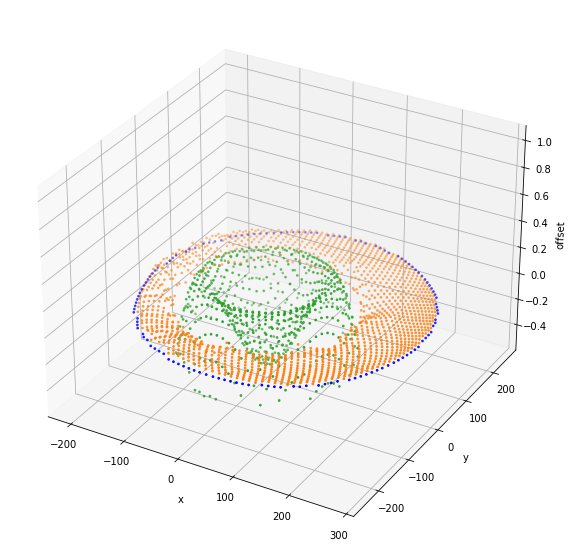

[-0.125274658203125, -0.035675048828125, -0.066864013671875, -0.17730712890625, -0.213897705078125, -0.115997314453125, -0.02410888671875, 0.045928955078125, 0.01513671875, -0.00360107421875]


In [37]:
draw_z_difference()

In [38]:
len_idle = len(edge_list_idling)
len_working = len(edge_list_working)
len_fixed = len(edge_list_fixing)
print(len_idle)
print(len_working)
print(len_fixed)
print(len_fixed+len_idle+len_working)
print(graph.n_edge)


cnt= 0
for e in edge_list_idling:
    if isworking(e.v1) or isworking(e.v2):
        cnt+=1
print(cnt)

4429
1986
110
6525
6525
168


100%|██████████| 130/130 [00:00<00:00, 47459.27it/s]


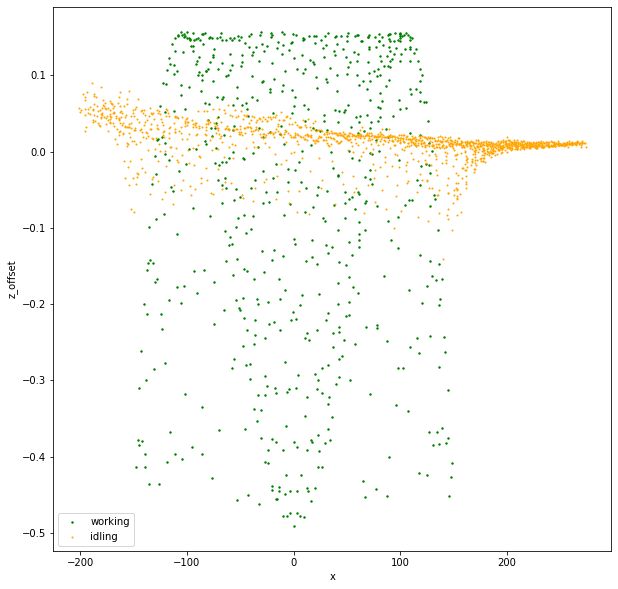

[-0.125274658203125, -0.035675048828125, -0.066864013671875, -0.17730712890625, -0.213897705078125, -0.115997314453125, -0.02410888671875, 0.045928955078125, 0.01513671875, -0.00360107421875]


In [40]:
def draw_z_difference_2D():
    x_working_, y_working_, z_working_ = [],[],[]
    x_fixing_ , y_fixing_ , z_fixing_  = [],[],[]
    x_idling_ , y_idling_ , z_idling_  = [],[],[]
    x_critic_ , y_critic_ , z_critic_  = [],[],[]

    for v in tqdm(vertex_list_working,):
        offset = v.z - v.info.init_pos.z
        if offset < 0.6:
            x_working_.append(float(v.x))
            y_working_.append(float(v.y))
            z_working_.append(float(offset))
        else:  
            x_critic_.append(float(v.x))
            y_critic_.append(float(v.y))
            z_critic_.append(float(offset))

    for v in tqdm(vertex_list_idling,):
        offset = v.z - v.info.init_pos.z
        x_idling_.append(float(v.x))
        y_idling_.append(float(v.y))
        z_idling_.append(float(offset))

    for v in tqdm(vertex_list_fixing,):
        offset = v.z - v.info.init_pos.z
        x_fixing_.append(float(v.x))
        y_fixing_.append(float(v.y))
        z_fixing_.append(float(offset))

    fig = plt.figure(figsize=(10, 10))
    plt.scatter(x_working_, z_working_, label = "working", s = 2, c = "g")
    plt.scatter(x_idling_,  z_idling_,  label = "idling",s = 1, c = "orange")
    plt.xlabel("x")
    plt.ylabel("z_offset")
    plt.legend(loc = "lower left")

    plt.show()
    print(z_working_[:10])
    
draw_z_difference_2D()

In [35]:

# for epoch in range(epochs):
#     optimizer = torch.optim.Adam(params = params_idle, lr = lr)
#     for step in range(steps):
#         optimizer.zero_grad()
#         total_ene = 0.
#         for e in edge_list_idling:
#             ene = edge_energy(e)
#             ene.backward()
#             total_ene += ene.detach().item()
#             if isworking(e.v1):
#                 e.v1.z = calc_z(e.v1.x, e.v1.y)
#             if isworking(e.v2):
#                 e.v2.z = calc_z(e.v2.x, e.v2.y)
        
#         Energy_list_list[epoch][step] = total_ene
            
#         optimizer.step()
#         print("[{}][{}]: {}".format(epoch, step, total_ene))
    
#     name_list = []
#     x_list = []
#     y_list = []
#     z_list = []
#     for v in tqdm(graph.vertex_list):
#         name_list.append(v.name)
#         x_list.append(v.x.detach().item())
#         y_list.append(v.y.detach().item())
#         z_list.append(v.z.detach().item())

#     df = pd.DataFrame({"INDEX": name_list,
#                     "X": x_list,
#                     "Y": y_list,
#                     "Z": z_list,})
#     lr *= 0.9
#     k_timer *= 1.1
#     df.to_excel("result_outer/{}.xlsx".format(epoch))
a=0

In [36]:
# draw_z_difference()

In [37]:
# draw_offset_difference()

# Traning Altogether

In [75]:
param_all:List[torch.Tensor] = []

for v in vertex_list_working:
    param_all.append(v.x)
    param_all.append(v.y)

for v in vertex_list_idling:
    param_all.append(v.x)
    param_all.append(v.y)
    param_all.append(v.z)

print(len(param_all))

5596


In [71]:
k_timer1 = 5.
k_timer2 = 10.


def edge_energy(edge:Edge):
    l0 = edge.info.length_original
    l_max1 = l0 * 4.5E-4
    l_max2 = l0 * 6.5E-4
    delta_L = torch.abs(edge.length - l0)
    K = c1 / l0
    if delta_L < l_max1:
        return 0.5 * K * delta_L ** 2
    elif delta_L < l_max2:
        return 0.5 * K * l_max1 ** 2 + k_timer1 * K * (delta_L - l_max1) * l_max1
    else:
        return 0.5 * K * l_max1 ** 2 + k_timer1 * K * (l_max2 - l_max1) * l_max1 +  k_timer2 * K * (delta_L - l_max2) * l_max1

Text(0, 0.5, 'energy')

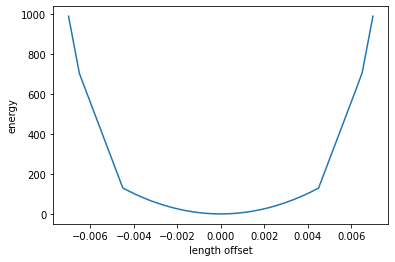

In [72]:
off_set_max = 10*7E-4
x_list = torch.linspace(-off_set_max,off_set_max, 1001)
y_list = []
Origin = Point(0.,0.,0.)
for x in x_list:
    p = Point(x+10., 0.,0.,)
    e = Edge(Origin, p)
    e.info = Edge_Info(length_original=10.,)
    y_list.append(edge_energy(e))
y_list = torch.tensor(y_list)
plt.plot(x_list, y_list)
plt.xlabel("length offset")
plt.ylabel("energy")

In [ ]:
# for v in vertex_list_idling:
#     x = v.x.detach.item()
#     y = v.y.detach.item()
#     v.z -= calc_z()
ls = []
for v in vertex_list_fixing:
    x = v.x.detach.item()
    y = v.y.detach.item()
    ls.append()


In [73]:
train = True
if train:
    lr = 0.00005
    epochs = 100
    steps = 50
    energy_list_list = np.zeros((epochs, steps))

    for epoch in range(epochs):

        optimizer = torch.optim.Adam(param_all, lr = lr)
                
        for step in range(steps):
            update_z(vertex_list_working)
            total_ene = 0.
            for edge in graph.edge_list:
                total_ene += edge_energy(edge)
            optimizer.zero_grad()
            total_ene.backward()
            optimizer.step()
            energy_list_list[epoch][step] = total_ene.detach().item()
            print("[{}][{}]: {}".format(epoch, step, total_ene))
        
        # saving
        name_list = []
        x_list = []
        y_list = []
        z_list = []
        for v in tqdm(graph.vertex_list):
            name_list.append(v.name)
            x_list.append(v.x.detach().item())
            y_list.append(v.y.detach().item())
            z_list.append(v.z.detach().item())

        df = pd.DataFrame({"INDEX": name_list,
                           "X": x_list,
                           "Y": y_list,
                           "Z": z_list,})
        df.to_excel("result_final/{}.xlsx".format(epoch+50))
        lr *= 0.8
        
        # testing
        cnt = 0
        for e in graph.edge_list:
            if torch.abs(e.length-e.info.length_original) >  e.info.max_offset:
                cnt += 1
        print("counter = ", cnt)
        print("ratio = ", cnt/graph.n_edge)


[0][0]: 667344.75
[0][1]: 671127.9375
[0][2]: 670451.25
[0][3]: 669278.1875
[0][4]: 668617.25
[0][5]: 668251.0625
[0][6]: 668071.8125
[0][7]: 667914.625
[0][8]: 667623.25
[0][9]: 667350.75
[0][10]: 667245.6875
[0][11]: 667142.6875
[0][12]: 666959.875
[0][13]: 666855.375
[0][14]: 666731.1875
[0][15]: 666568.0
[0][16]: 666435.1875
[0][17]: 666330.9375
[0][18]: 666258.4375
[0][19]: 666123.9375
[0][20]: 665995.1875
[0][21]: 665831.0625
[0][22]: 665662.5625
[0][23]: 665592.5
[0][24]: 665493.5625
[0][25]: 665364.1875
[0][26]: 665266.6875
[0][27]: 665210.875
[0][28]: 665084.5625


KeyboardInterrupt: 

In [74]:
cnt = 0
for e in graph.edge_list:
    if torch.abs(e.length-e.info.length_original) >  e.info.max_offset:
        cnt += 1
print("counter = ", cnt)
print("ratio = ", cnt/graph.n_edge)

counter =  45
ratio =  0.006896551724137931


In [67]:
name_list = []
x_list = []
y_list = []
z_list = []
for v in tqdm(graph.vertex_list):
    name_list.append(v.name)
    x_list.append(v.x.detach().item())
    y_list.append(v.y.detach().item())
    z_list.append(v.z.detach().item())

df = pd.DataFrame({"INDEX": name_list,
                "X": x_list,
                "Y": y_list,
                "Z": z_list,})
df.to_excel("result_final/{}.xlsx".format(epoch+52))

100%|██████████| 2226/2226 [00:00<00:00, 117043.01it/s]


100%|██████████| 6525/6525 [00:12<00:00, 502.12it/s]


43


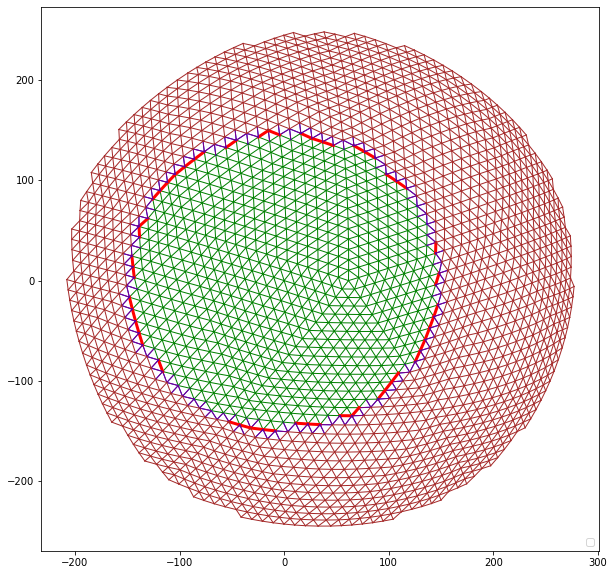

43


In [69]:
cnt = 0
cnt2 =0
err = []
fig = plt.figure(figsize=(10, 10))
for edge in tqdm(graph.edge_list):
    if isworking(edge.v1) != isworking(edge.v2):
        plt.plot([edge.v1.x.detach().numpy(), edge.v2.x.detach().numpy()], [edge.v1.y.detach().numpy(), edge.v2.y.detach().numpy()], c = "b", linewidth= 1)#, label = "transition")
    if isworking(edge.v1) and isworking(edge.v2):
        plt.plot([edge.v1.x.detach().numpy(), edge.v2.x.detach().numpy()], [edge.v1.y.detach().numpy(), edge.v2.y.detach().numpy()], c = "green", linewidth= 1)#, label = "working")
    elif not isworking(edge.v1) and not isworking(edge.v2):
        plt.plot([edge.v1.x.detach().numpy(), edge.v2.x.detach().numpy()], [edge.v1.y.detach().numpy(), edge.v2.y.detach().numpy()], c = "brown", linewidth= 1)#, label = "idling")
    else:
        plt.plot([edge.v1.x.detach().numpy(), edge.v2.x.detach().numpy()], [edge.v1.y.detach().numpy(), edge.v2.y.detach().numpy()], c = "purple", linewidth= 1)#, label = "fixing")

    # if torch.abs(edge.length-edge.info.length_original) != 0:
        # print(torch.abs(edge.length-edge.info.length_original))
        # print(edge.info.length_original*7E-4)
    
    if torch.abs(edge.length-edge.info.length_original) >  edge.info.length_original*7E-4:
        cnt2 += 1
    if torch.abs(edge.length-edge.info.length_original) >  edge.info.max_offset:
        if edge.length-edge.info.length_original > 0:
            plt.plot([edge.v1.x.detach().numpy(), edge.v2.x.detach().numpy()], [edge.v1.y.detach().numpy(), edge.v2.y.detach().numpy()], c = "r", linewidth = 3)#, label = "stretching")
            err.append(edge)
        else:
            plt.plot([edge.v1.x.detach().numpy(), edge.v2.x.detach().numpy()], [edge.v1.y.detach().numpy(), edge.v2.y.detach().numpy()], c = "orange", linewidth = 3)#, label = "shrinking")

        cnt+=1
print(cnt)
plt.legend(loc="lower right")
plt.show()
print(cnt2)
# print(cnt)
# cnt = 0
# for e in el:
#     if torch.abs(e.length-e.info.length_original) >  e.info.max_offset:
#         cnt+=1
# print(cnt)


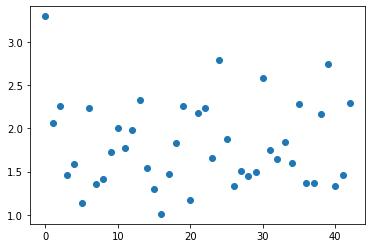

In [70]:
ls = []
for edge in err:
    ls.append(((edge.length-edge.info.length_original)/edge.info.max_offset).detach().item())
plt.scatter(np.arange(len(ls)), ls)

In [ ]:



if True:

    x1 = torch.tensor([1.], requires_grad=True)
    y1 = torch.tensor([1.], requires_grad=True)
    z1 = torch.tensor([1.], requires_grad=True)
    x2 = torch.tensor([2.], requires_grad=True)
    y2 = torch.tensor([2.], requires_grad=True)
    z2 = torch.tensor([2.], requires_grad=True)
    x3 = torch.tensor([3.], requires_grad=True)
    y3 = torch.tensor([3.], requires_grad=True)
    z3 = torch.tensor([3.], requires_grad=True)

    v1 = Point(x1, y1, z1)
    v2 = Point(x2, y2, z2)
    v3 = Point(x3, y3, z3)
    test_e1 = Edge(v1, v2)
    test_e2 = Edge(v2, v3)
    test_e1.info = Edge_Info(2.)
    test_e2.info = Edge_Info(2.)

    optimizer = torch.optim.Adam([x1, v2.x, v2.y])#,x2,y1,y2,z1,z2])


    for i in range(10):
        optimizer.zero_grad()
        loss1 = edge_energy(test_e1)
        loss1.backward()
        loss2 = edge_energy(test_e2)
        loss2.backward()
        optimizer.step()
        print(loss1.detach().item()+loss2.detach().item())


474910.28125
474395.890625
473879.703125
473361.578125
472840.609375
472316.546875
471789.296875
471259.015625
470725.171875
470187.75
